# Passange Survival by Fare paid on HMS Titanic 

[Kaggle Competition](https://www.kaggle.com/c/titanic)

In [0]:
# EDA
import numpy as np
import pandas as pd
#import modin.pandas as pd
import missingno
import seaborn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime as dt
from pandas.plotting import scatter_matrix

# preprocessing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition

# algos
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [12]:
# load data
!wget https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/train.csv
!wget https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/test.csv

#
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

--2020-05-01 19:38:21--  https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  59.76K  --.-KB/s    in 0.008s  

2020-05-01 19:38:21 (7.17 MB/s) - ‘train.csv.1’ saved [61194/61194]

--2020-05-01 19:38:22--  https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awai

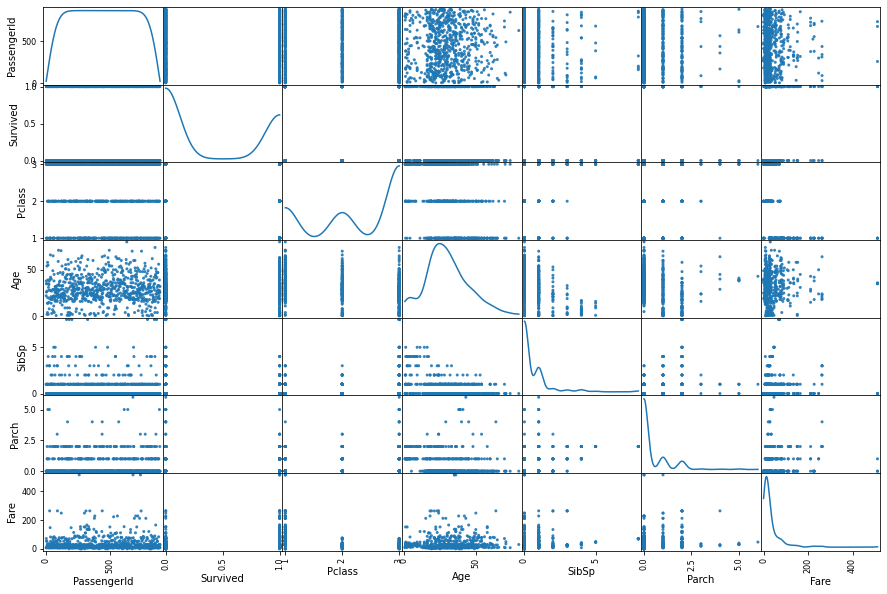

In [14]:
# scatterplot matrix on numerical features
scatter_matrix(dftrain, figsize=(15,10), alpha=.9, diagonal='kde')
plt.show()

In [20]:
# dtype data review
dftrain.info()
print(f'========================================')
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [37]:
# 
dftrain.isnull().sum()
dftest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [64]:
# only 1 value for 'Fare' missing
print(dftrain['Fare'].mean())
print(dftrain['Fare'].median())
print(dftrain['Fare'].mode())

impute = dftest['Fare'].median()

dftest['Fare'].fillna(impute, inplace=True)

32.2042079685746
14.4542
0    8.05
dtype: float64


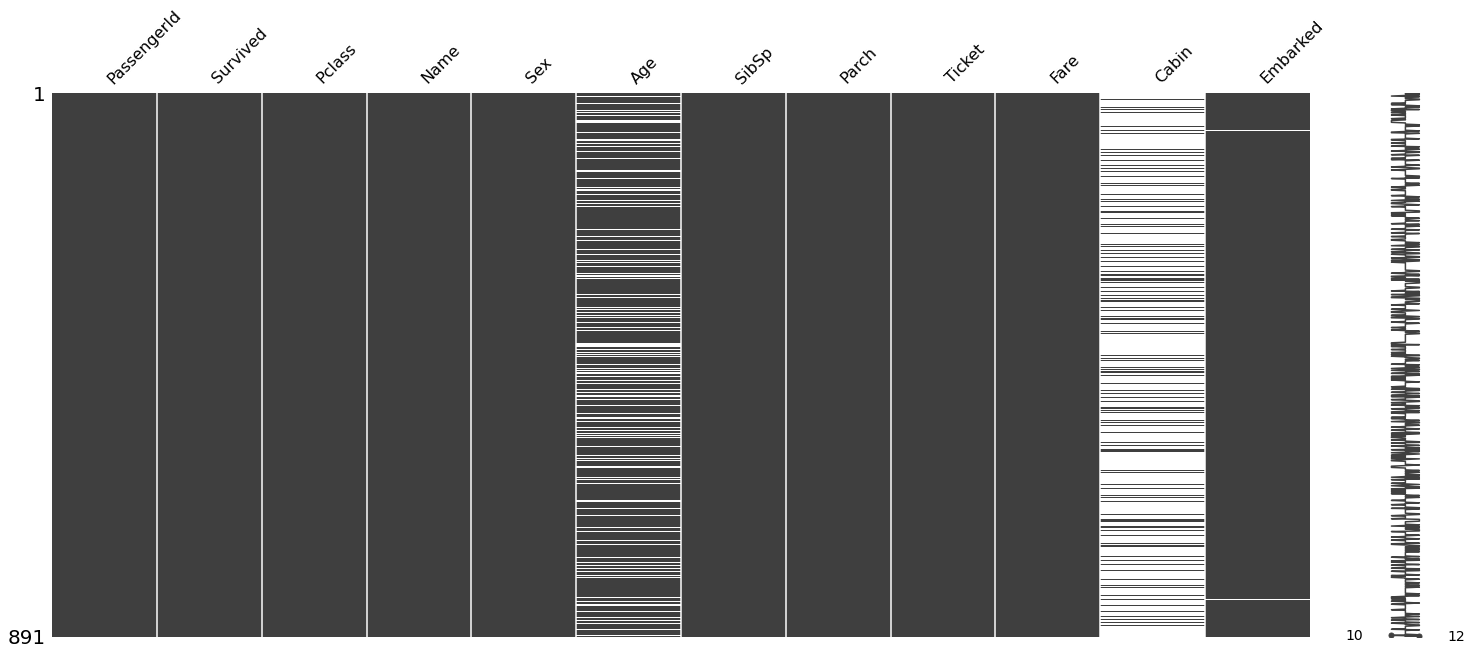

In [70]:
# train dataset missing values
missingno.matrix(dftrain)
plt.show()

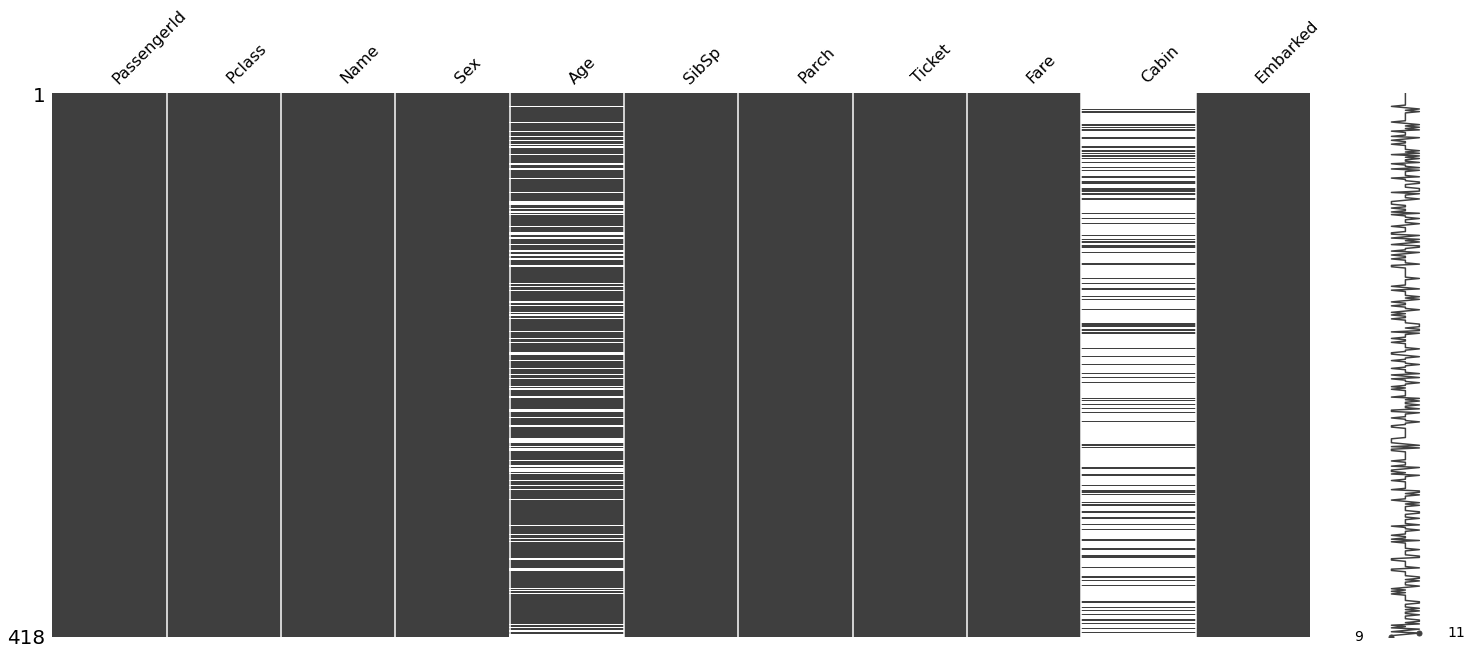

In [69]:
# test dataset missing values
missingno.deno(dftest)
plt.show()

In [184]:
# 
dftrain.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
dftrain['Sex'] = dftrain['Sex'].astype('category')
dftest['Sex'] = dftest['Sex'].astype('category')

In [176]:
dftrain['Sex'].cat.codes
dftest['Sex'].cat.codes

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Length: 891, dtype: int8

In [0]:
# predictor selection
predictors_train = pd.concat([dftrain['Pclass'], dftrain['Fare'], dftrain['Sex'].cat.codes], axis=1)
predictors_test = pd.concat([dftest['Pclass'], dftest['Fare'], dftest['Sex'].cat.codes], axis=1)

In [183]:
predictors_train

,Pclass,Fare,0
0,3,7.2500,1
1,1,71.2833,0
2,3,7.9250,0
3,1,53.1000,0
4,3,8.0500,1
...,...,...,...
886,2,13.0000,1
887,1,30.0000,0
888,3,23.4500,0
889,1,30.0000,1


In [0]:
# 
X_train = predictors_train.values
X_test = predictors_test.values

In [0]:
# target variable
y_train = dftrain['Survived'].values

In [187]:
# training sample
X_train[:5]

array([[ 3.    ,  7.25  ,  1.    ],
       [ 1.    , 71.2833,  0.    ],
       [ 3.    ,  7.925 ,  0.    ],
       [ 1.    , 53.1   ,  0.    ],
       [ 3.    ,  8.05  ,  1.    ]])

In [188]:
# target variable sample
y_train[:5]

array([0, 1, 1, 1, 0])

### Grid Search

In [0]:
# Grid Search | LR
model_LogReg = LogisticRegression()

# Create regularization hyperparameter space
C = [1, 2, 3, 4]

In [0]:
#
params_LR={'penalty': ['l1', 'l2', 'none'],
              'C': [1, 2, 3, 4],
              'solver': ['newton-cg’' ,'lbfgs', 'liblinear', 'sag', 'saga']}

In [0]:
#
grid_LogReg = GridSearchCV(model_LogReg,
                            params_LR,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error')

In [209]:
# 
grid_LogReg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4], 'penalty': ['l1', 'l2', 'none'],
                         'solver': ['newton-cg’', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [210]:
# best LR paremeters
grid_LogReg.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

### Logistic Regression Model

In [0]:
# tuned model
model_LogReg_tuned = LogisticRegression(C=1, penalty='l2', solver='liblinear')

In [214]:
# fit tuned model to data
model_LogReg_tuned.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [221]:
# 
y_train_pred = model_LogReg_tuned.predict(X_train)
y_test_pred = model_LogReg_tuned.predict(X_test)

print(f'{y_train_pred}')
print(f'===============================================================')
print(f'{y_test_pred}')

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 0 1 0 1 1 0 0 0 0 0 0 

In [223]:
#compute training error
M = np.hstack([y_train[:,None],y_train_pred[:,None]])
print(f'{M}')

[[0 0]
 [1 1]
 [1 1]
 ...
 [0 1]
 [1 0]
 [0 0]]


In [232]:
# Accuracy Score
print(f'{(y_train == y_train_pred).mean()*100:.5}%')

78.227%


---

### XGBoost